In [47]:
import esda
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from copy import deepcopy
from scipy.spatial.distance import cdist
from scipy import stats
from math import log as ln
import pathlib
from libpysal import weights

zipcode_file = pathlib.Path("/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/tl_2017_us_zcta510.zip")
# Check existence
if zipcode_file.exists():
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
else:
    print("File not found! Make sure it's in the current directory.")

data_indexes = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/indexes'
data_destinations = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/destinations'
data_osm = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/osm'
data_filtered_destinations = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/filtered_destinations'

osm_types = {
    'building': ['building'],
    'commercial': ['shop', 'tourism', 'office'],
    'emergency': ['emergency'],
    'government': ['government', 'military'],
    'healthcare': ['healthcare'],
    'landuse': ['landuse'],
    'natural': ['natural'],
    'power': ['power', 'backup_generator'],
    'public': ['historic'],
    'sport': ['sport'],
    'transportation': ['aeroway', 'highway', 'railway', 'waterway'],
}

amenities = {
    'commercial': ['marketplace', 'restaurant', 'fast_food', 'cafe', 'bar', 'pub'],
    'education': ['kindergarten', 'school', 'college', 'university', 'language_school'],
    'emergency': ['police', 'fire_station'],
    'financial': ['atm', 'bank', 'bureau_de_change', 'microfinance', 'mobile_money_agent', 'money_transfer'],
    'governement': ['court_house', 'townhall', 'embassy', 'post_office'],
    'healthcare': ['doctors', 'dentist', 'clinic', 'toilets', 'hospital', 'pharmacy'],
    'power': ['fuel'],
    'public': ['place_of_worship', 'community_centre', 'library', 'toilets'],
    'transportation': ['ferry_terminal', 'bus_station']
}

leisures = {
    'sport': ['stadium', 'swimming pool', 'pitch', 'sport_centre'],
    'landuse': ['park'],
}

color = sns.color_palette("coolwarm", as_cmap=True)
sns.set_theme(style="whitegrid")

In [48]:
def plot_pois_and_indexes(gdf, city, variable):
    """
    Plots the POIs and the index on a map.
    """
    # normalization poi_density
    max_density = gdf["poi_density"].max()
    gdf["poi_density"] = gdf["poi_density"] / max_density

    # plot the data
    _, axes = plt.subplots(1, 2, figsize=(15, 7))

    gdf.plot(column="poi_density", ax=axes[0], legend=True, cmap=color, vmin=0, vmax=1)
    axes[0].set_title(f"POI Density in {city}")

    gdf.plot(column=variable, ax=axes[1], legend=True, cmap=color, vmin=0, vmax=ln(9))
    if variable == 'gender':
        variable = 'age'
    axes[1].set_title(f"Destination Mixing Index ({variable}) in {city}")
    sns.set_style("whitegrid")
    plt.show()

def get_scatterplot(gdf, city):
    """
    Plots the scatter plot for POI density and indexes.
    """
    # plot the scatter plot for poi density (x) and indexes (y)
    plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")
    sns.scatterplot(data=gdf, x="poi_density", y="family", alpha=0.5, label="Family")
    sns.scatterplot(data=gdf, x="poi_density", y="nonfamily", alpha=0.5, label="Non Family")
    sns.scatterplot(data=gdf, x="poi_density", y="married", alpha=0.5, label="Married")
    sns.scatterplot(data=gdf, x="poi_density", y="household", alpha=0.5, label="Household")
    plt.title("POI Density vs Indexes for " + city)
    plt.xlabel("POI Density")
    plt.ylabel("Indexes")
    plt.legend()
    plt.show()

def plot_distances(gdf, city):
    """
    Plot the spatial and regular Pearson correlation for different distances.
    """
    sns.lineplot(data=gdf, x='Distance', y='Spatial Pearson', label='Spatial Pearson Correlation')
    sns.lineplot(data=gdf, x='Distance', y='Regular Pearson', label='Regular Pearson Correlation')
    plt.legend()
    plt.xticks(np.arange(500, 7000, 500), rotation=45)
    plt.suptitle('Spatial Pearson Correlation vs Regular Pearson Correlation for ' + city)
    plt.xlabel("Distance (m)")
    plt.ylabel("Spatial Pearson Correlation")
    plt.xlabel("Distance (m)")
    plt.ylabel("Regular Pearson Correlation")
    sns.set_style("whitegrid")
    plt.show()

def get_pois(city, type = None):
    """
    Function to get the category of the POIs in the city
    """
    print('reading the zipcodes data')

    print('reading the POIs data')
    path_osm = os.path.join(data_osm, city + '.geojson')
    df_osm = gpd.read_file(path_osm).to_crs(zipcode_gdf.crs)

    # filter the POIs by type and the leisure dictionary
    new_df = deepcopy(df_osm)

    # clear the dataframe
    new_df.drop(new_df.index, inplace=True)
    if type:
        if type in osm_types:
            for key in osm_types[type]:
                df = df_osm.loc[df_osm[key].notnull()]
                new_df = pd.concat([new_df, df])
        
        if type in amenities:
            for key in amenities[type]:
                df = df_osm.loc[df_osm['amenity'] == key]
                new_df = pd.concat([new_df, df])
        
        if type in leisures:
            for key in leisures[type]:
                df = df_osm.loc[df_osm['leisure'] == key]
                new_df = pd.concat([new_df, df])

        return new_df
    
    return df_osm

In [49]:
def compute_centroid(geom):
    if geom.geom_type == 'Polygon':
        x = np.mean(geom.exterior.coords.xy[0])
        y = np.mean(geom.exterior.coords.xy[1])
    else:
        x = geom.centroid.x
        y = geom.centroid.y
    return (x, y)

def Compute_SPearson(weights_matrix, v1, v2):
    r = esda.Spatial_Pearson(connectivity = weights_matrix)
    r.fit(v1,v2)
    A = r.association_[0][1]
    del(r)
    return A

def scc(city, zipcode_gdf, variable, type = None, filtered = False):

    path = os.path.join(data_indexes, city + '.csv')
    df = pd.read_csv(path, encoding='cp1252', dtype={'zipcode': str})

    if filtered:
        destination_path = os.path.join(data_filtered_destinations, city + '.csv')
    else:
        destination_path = os.path.join(data_destinations, city + '.csv')
    
    df_index = pd.read_csv(destination_path, encoding='cp1252', dtype={'zipcode': str})
    print(df_index.head())

    # get only the zipcodes that are in the index map, remove station column
    zicodes = df["zipcode"].unique()
    df_index =  df_index[df_index["zipcode"].isin(zicodes)].drop(columns=["station"]).groupby("zipcode").mean().reset_index()

    # in the DataFrame there are multiple lines for the same zipcode, so we need to group them
    df_index = df_index.groupby("zipcode").mean().reset_index()
    
    df_osm = get_pois(city, type)

    # add the zipcodes to the dataframe using sjoin -> zipcode and ZCTA5CE10 columns
    pois_by_zip = gpd.sjoin(df_osm, zipcode_gdf, how="inner", predicate="within")

    # rename the columns
    pois_by_zip.rename(columns={"ZCTA5CE10": "zipcode"}, inplace=True)
    zipcode_gdf.rename(columns={"ZCTA5CE10": "zipcode"}, inplace=True)

    # group the data by zipcode (count the number of points in each zipcode)
    poi_counts = pois_by_zip.groupby("zipcode").size().reset_index(name="poi_count")

    zipcode_gdf = zipcode_gdf.merge(df_index, on="zipcode", how="left")
    zipcode_gdf = zipcode_gdf.merge(poi_counts, on="zipcode", how="left")
    zipcode_gdf["poi_count"] = zipcode_gdf["poi_count"].fillna(0)  # Fill ZIP codes with no POIs

    zipcode_gdf.to_crs(epsg=3857, inplace=True)
    zipcode_gdf["poi_density"] = zipcode_gdf["poi_count"] / zipcode_gdf["geometry"].area

    # select only zipcodes with at least one POI
    zipcode_gdf = zipcode_gdf[zipcode_gdf["poi_count"] > 0]
    
    # select only zipcodes in the index dataframe
    zipcode_gdf = zipcode_gdf[zipcode_gdf["zipcode"].isin(df_index["zipcode"])]

    max_density = zipcode_gdf["poi_density"].max()
    zipcode_gdf["poi_density"] = zipcode_gdf["poi_density"] / max_density

    print(zipcode_gdf.columns)
    
    plot_pois_and_indexes(zipcode_gdf, city, variable)

    return zipcode_gdf

def compute_spatial_pearson(city, zipcode_gdf):
    
    df1 = zipcode_gdf.copy()
    df2 = zipcode_gdf.copy()

    coords_df1 = list(df1.geometry.apply(compute_centroid))
    coords_df2 = list(df2.geometry.apply(compute_centroid))
    dist_matrix = cdist(coords_df1, coords_df2)

    r_spatial,r_p = [],[]
    results = pd.DataFrame(columns=['Distance', 'Spatial Pearson', 'Regular Pearson'])
    vals = np.arange(500, 7000, 1)
    for D in vals:
        # consider using weights decaying exponentially with distance
        weights_matrix = np.where(dist_matrix <= D, 1, 0)

        v1 = np.array(df1.poi_density)
        v2 = np.array(df2.race)
        
        # standardize the variables
        v1 = (v1 - v1.mean()) / v1.std()
        v2 = (v2 - v2.mean()) / v2.std()

        # reshape the variables
        v1 = v1.reshape(-1, 1)
        v2 = v2.reshape(-1, 1)
        
        pearson = Compute_SPearson(weights_matrix, v1, v2)
        r, p = stats.pearsonr(v1.flatten(), v2.flatten())

        if D % 500 == 0:
            print(f"Distance: {D} m")
            print('spatial pearson correlation: ', pearson)

            print("Regular Pearson Correlation:", r, "p-value:", p)
            print("\n")

        r_spatial.append(pearson)
        r_p.append(r)

    results['Distance'] = vals
    results['Spatial Pearson'] = r_spatial
    results['Regular Pearson'] = r_p

    plot_distances(results, city)

In [50]:
import libpysal

def compute_lisa(gdf, variable, city, k=4):
    """
    local indicator of spatial association (LISA) calculation and plotting.
    
    Args:
        gdf (GeoDataFrame): GeoDataFrame con geometrie e la variabile di interesse.
        variable (str): Nome della colonna su cui calcolare LISA.
        k (int): Numero di vicini da considerare (default=8).
        plot (bool): Se True, disegna la mappa dei cluster.
        
    Returns:
        gdf (GeoDataFrame): GeoDataFrame con colonne aggiunte:
            - lisa_I: valore del local Moran's I
            - lisa_p: p-value
            - lisa_cluster: cluster type (HH, LL, HL, LH, NS)
    """
    # Costruisci matrice di pesi basata su k-nearest neighbors
    w = libpysal.weights.KNN.from_dataframe(gdf, k=k)
    w.transform = 'r'  # normalizza i pesi
    
    # Estrai variabile come array
    #gdf, _ = merge_indexes_with_zipcodes(city, zipcode_gdf)
    print(gdf.columns)
    y = gdf[variable].values
    
    # Calcola Local Moran
    lisa = esda.Moran_Local(y, w)
    
    # Aggiungi risultati al GeoDataFrame
    gdf["lisa_I"] = lisa.Is
    gdf["lisa_p"] = lisa.p_sim
    gdf["lisa_cluster"] = lisa.q
    
    # Categorizza cluster (1=HH, 2=LH, 3=LL, 4=HL)
    cluster_labels = {
        1: "HH",
        2: "LH",
        3: "LL",
        4: "HL"
    }
    
    gdf["lisa_cluster"] = gdf["lisa_cluster"].map(cluster_labels)
    
    _, ax = plt.subplots(1, 1, figsize=(7, 7))
    gdf.plot(column="lisa_cluster", categorical=True, 
                cmap=color, legend=True, ax=ax,
                legend_kwds={'title': "LISA Cluster"})
    plt.title(f"LISA Cluster Map for {variable} in {city}")
    plt.show()

                                       station zipcode    gender  household  \
0                 MIT Hayward St at Amherst St   02142  2.545607   2.082683   
1                           Mass Ave T Station   02118  2.584708   2.102981   
2  Northeastern University - North Parking Lot   02115  2.463996   2.129531   
3                Bartlett St at John Elliot Sq   02119  2.531153   2.167426   
4                   Clarendon Hill at Broadway   02144  2.595079   2.036647   

     family  nonfamily   married      race  
0  1.844624   2.159401  1.603287  1.406445  
1  1.889096   2.151754  1.652265  1.404688  
2  1.918429   2.174136  1.697613  1.418444  
3  2.027579   2.177698  1.800120  1.491433  
4  1.793045   2.131699  1.600315  1.238626  
reading the zipcodes data
reading the POIs data
Index(['zipcode', 'GEOID10', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'gender',
       'household', 'family', 'nonfamily', 'married', 'race'

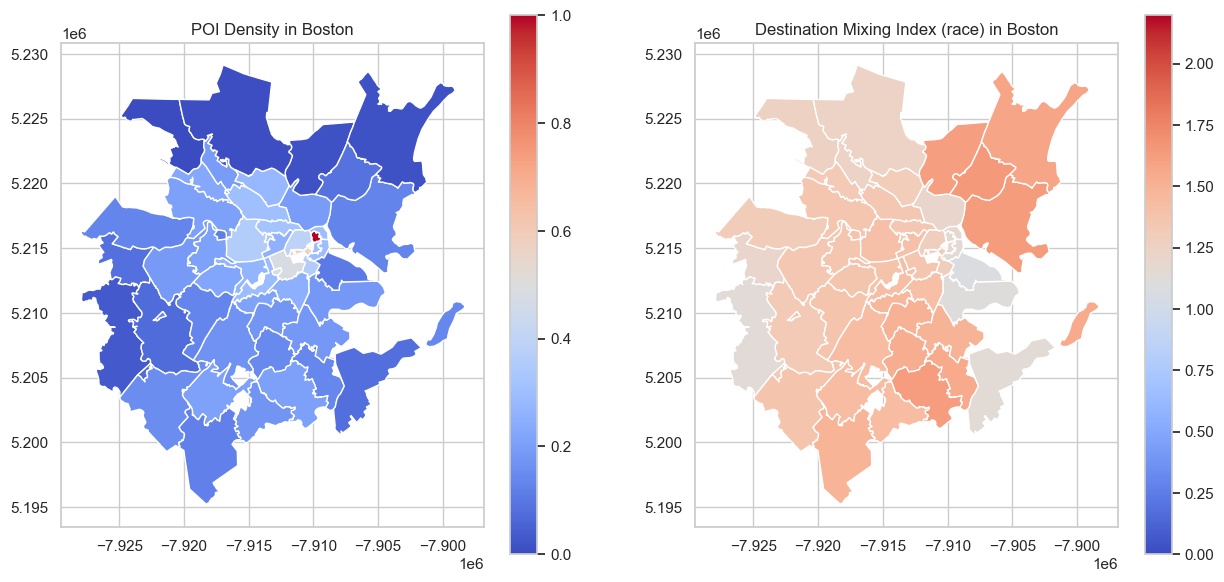

In [51]:
city = "Boston"
variable = "race"
gdf = scc(city, zipcode_gdf, variable)

Distance: 500 m
spatial pearson correlation:  -0.5623915736271468
Regular Pearson Correlation: -0.21450118107853974 p-value: 0.13886395486668823


Distance: 1000 m
spatial pearson correlation:  -0.6894968736002876
Regular Pearson Correlation: -0.21450118107853974 p-value: 0.13886395486668823


Distance: 1500 m
spatial pearson correlation:  -0.9152847172359265
Regular Pearson Correlation: -0.21450118107853974 p-value: 0.13886395486668823


Distance: 2000 m
spatial pearson correlation:  -0.697438284662932
Regular Pearson Correlation: -0.21450118107853974 p-value: 0.13886395486668823


Distance: 2500 m
spatial pearson correlation:  -0.5416151675602754
Regular Pearson Correlation: -0.21450118107853974 p-value: 0.13886395486668823


Distance: 3000 m
spatial pearson correlation:  -0.45980107120977404
Regular Pearson Correlation: -0.21450118107853974 p-value: 0.13886395486668823


Distance: 3500 m
spatial pearson correlation:  -0.415409741292975
Regular Pearson Correlation: -0.214501181078539

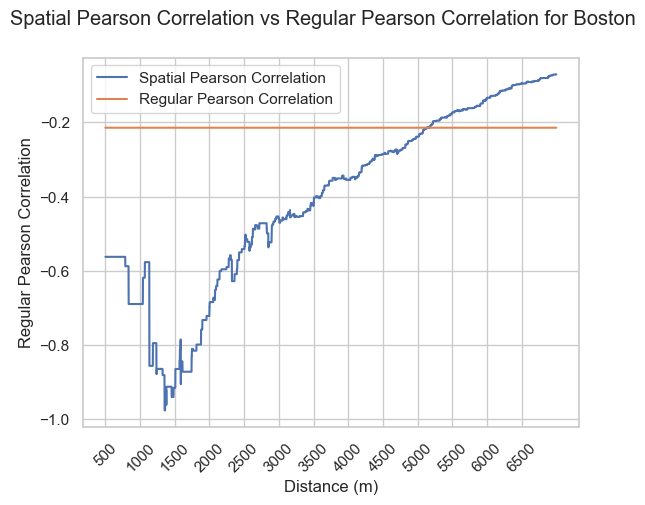

In [52]:
compute_spatial_pearson(city, gdf)

Index(['zipcode', 'GEOID10', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'gender',
       'household', 'family', 'nonfamily', 'married', 'race', 'poi_count',
       'poi_density'],
      dtype='object')


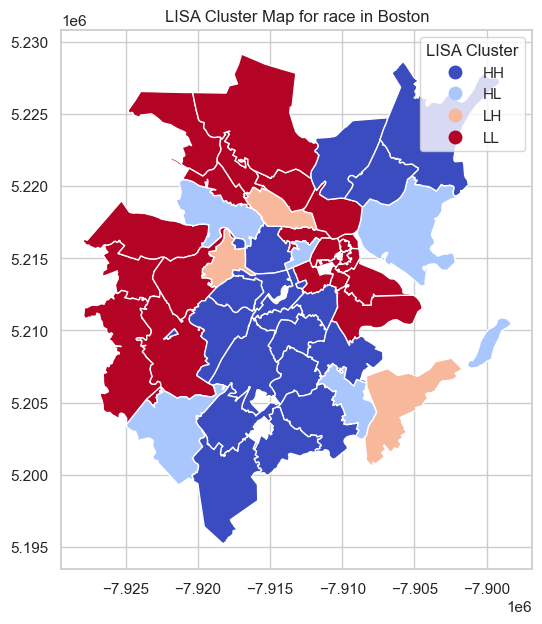

In [53]:
compute_lisa(gdf, variable, city)